# Accessing AIGFS forecast output from the Unidata THREDDS Data Server using Siphon and MetPy

## Notebook Goal

Use Siphon and Metpy to load the latest run of the AIGFS into an xarray dataset based on the [AIGFS catalog](https://thredds.ucar.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.html) from the Unidata THREDDS Data Server.

## Requirements

Conda environment yaml:

```yml
name: aigfs
channels:
  - conda-forge
dependencies:
  - python>=3.14
  - siphon
  - metpy
  - jupyter
```

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import time

from metpy.units import units
from siphon.catalog import TDSCatalog

### Open the Remote Dataset

Use Siphon to parse the THREDDS client catalog for the AIGFS dataset from the [NSF Unidata TDS](https://thredds.ucar.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.html), or the [University of Wisconsin - Madison department of Atmospheric and Oceanic Sciences TDS](https://thredds.aos.wisc.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.html), and remotely open the latest dataset using xarray and metpy accessors.
Note that very little data is transfered in this process; at no point will we download the entire 5+ GiB of grib messages.

In [2]:
catalog_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.xml'
# uncomment below to access data from the University of Wisconsin - Madison
# department of Atmospheric and Oceanic Sciences TDS
#catalog_url = 'https://thredds.aos.wisc.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.xml'
cat = TDSCatalog(catalog_url)
ds = cat.latest.remote_access(use_xarray=True).metpy.parse_cf()

In [3]:
ds

<xarray.Dataset> Size: 23GB
Dimensions:                                                   (time: 127, : 2,
                                                               lat: 721,
                                                               lon: 1440,
                                                               time1: 65,
                                                               isobaric: 13,
                                                               height_above_ground1: 1,
                                                               height_above_ground: 1)
Coordinates:
  * time                                                      (time) datetime64[ns] 1kB ...
  * lat                                                       (lat) >f4 3kB 9...
  * lon                                                       (lon) >f4 6kB 0...
  * time1                                                     (time1) datetime64[ns] 520B ...
  * isobaric                                                  (isobaric) >f4 52B ...
  * height_above_ground1                                      (height_above_ground1) >f4 4B ...
  * height_above_ground                                       (height_above_ground) >f4 4B ...
    reftime                                                   datetime64[ns] 8B ...
    metpy_crs                                                 object 8B Proje...
Dimensions without coordinates: 
Data variables: (12/13)
    LatLon_Projection                                         int32 4B ...
    time_bounds                                               (time, ) datetime64[ns] 2kB ...
    Geopotential_height_isobaric                              (time1, isobaric, lat, lon) float32 4GB ...
    Pressure_reduced_to_MSL_msl                               (time1, lat, lon) float32 270MB ...
    Specific_humidity_isobaric                                (time1, isobaric, lat, lon) float32 4GB ...
    Temperature_isobaric                                      (time1, isobaric, lat, lon) float32 4GB ...
    ...                                                        ...
    Total_precipitation_surface_Mixed_intervals_Accumulation  (time, lat, lon) float32 527MB ...
    Vertical_velocity_pressure_isobaric                       (time1, isobaric, lat, lon) float32 4GB ...
    u-component_of_wind_isobaric                              (time1, isobaric, lat, lon) float32 4GB ...
    u-component_of_wind_height_above_ground                   (time1, height_above_ground, lat, lon) float32 270MB ...
    v-component_of_wind_isobaric                              (time1, isobaric, lat, lon) float32 4GB ...
    v-component_of_wind_height_above_ground                   (time1, height_above_ground, lat, lon) float32 270MB ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   2,1
    Type_of_generating_process:           Forecast
    file_format:                          GRIB-2
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.internal.dataset.conv.CF1C...

Let's inspect the `Temperature_height_above_ground` variable, which as shown by the metadata, is the Temperature in Kelvin at 2.0m above ground level:

In [4]:
temperature = ds['Temperature_height_above_ground']
temperature

<xarray.DataArray 'Temperature_height_above_ground' (time1: 65,
                                                     height_above_ground1: 1,
                                                     lat: 721, lon: 1440)> Size: 270MB
[67485600 values with dtype=float32]
Coordinates:
  * time1                 (time1) datetime64[ns] 520B 2026-01-14T12:00:00 ......
  * height_above_ground1  (height_above_ground1) >f4 4B 2.0
  * lat                   (lat) >f4 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon                   (lon) >f4 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    reftime               datetime64[ns] 8B 2026-01-14T12:00:00
    metpy_crs             object 8B Projection: latitude_longitude
Attributes: (12/13)
    long_name:                       Temperature @ Specified height level abo...
    units:                           K
    abbreviation:                    TMP
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_0-0-0_L103
    Grib2_Parameter:                 [0 0 0]
    ...                              ...
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                103
    Grib2_Level_Desc:                Specified height level above ground
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

Finally, let's display a map of temperature two meters above the ground in degree Celsius for the 5th time step out from initilization. Note that the model output contains forecasts every six hours, so this would a the forecast valid 30 hours from the runtime of the model. Also note that up until this point, we've only read a minimal amount of data and metadata from the server. The call to `temperature[time_index,0,::]` in the `contourf` call will read one 2D slice of Temperature data from the server. **Again, at no point do we download the entire 5+ GiB of GRIB records from the server.**

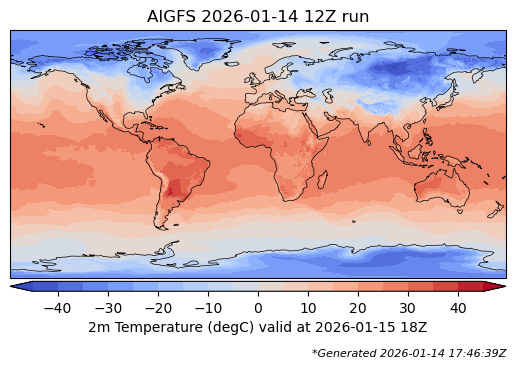

In [5]:
time_index = 5
runtime = dt.datetime.fromisoformat(str(temperature.reftime.values)).strftime('%Y-%m-%d %H')
valid_time = dt.datetime.fromisoformat(str(temperature.metpy.time.values[time_index])).strftime('%Y-%m-%d %H')
generation_time = dt.datetime.now(dt.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

display_units = 'degC'
temperature_range = np.arange(-45, 46, 5)
dataproj = temperature.metpy.cartopy_crs
plotproj = ccrs.PlateCarree()

fig = plt.figure(1)
ax = plt.subplot(111, projection=plotproj)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
plt.title('AIGFS {}Z run'.format(runtime))
cax = ax.contourf(temperature.metpy.longitude, temperature.metpy.latitude, 
             temperature[time_index,0,::].metpy.quantify().metpy.convert_units(display_units), 
             temperature_range, cmap = plt.cm.coolwarm, extend = 'both' )
cb = plt.colorbar(cax, orientation = 'horizontal', pad=0.01, aspect=50, extend=True, 
                  label='2m Temperature ({}) valid at {}Z'.format(display_units, valid_time))
figtext = plt.figtext(0.9, 0.07, '*Generated {}Z'.format(generation_time),
                      horizontalalignment='right', fontsize = 8, style = 'italic')